In [1]:
import sys
import os
sys.path.append('/usr0/home/drschwar/src/bert_brain/')
sys.path.append('/usr0/home/drschwar/src/subplot_artist')
sys.path.append('/usr0/home/drschwar/src/ocular')
sys.path.append('/usr0/home/drschwar/src/analytic_wavelet')
sys.path.append('/usr0/home/drschwar/src/analytic_wavelet_meg')
import json
import dataclasses
from collections import OrderedDict
from functools import partial

from tqdm.auto import trange, tqdm

import numpy as np
from scipy.stats import ttest_rel
from scipy.special import softmax
from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

import mne

from bert_brain_paths import Paths
from bert_brain import named_variations, task_hash, singleton_variation, \
    get_indices_from_normalized_coordinates, get_mask_for_subject, sentence_predictions, \
    read_variation_results, loss_curves_for_variation, average_unique_steps_within_loss_curves, \
    average_unique_epochs_within_loss_curves, average_over_runs, \
    two_sample_permutation_test, one_sample_permutation_test, Aggregator, sample_differences, \
    wilcoxon_axis, fdr_correction, read_predictions, k_vs_k, get_field_predictions, assemble_indexed_predictions, \
    get_model_weights, write_pairwise_metric_statistics, filter_pairwise_metric_statistics, StatisticsSpec, \
    compute_statistics_on_aggregated
from analysis import print_variation_results, text_heat_map_html, remove_hp_fmri_prefix
from ocular import keyed_colors, bar_eval_key, make_label, bar_grouped, make_bar_group, DisplayName, \
    bar_group_best_for_eval, cmap_rgba_bytes, make_vertex_data, comparison_cmap_rgba_bytes
from element_analysis_harry_potter import dipole_aggregate
from occlusion import run_occlusion, read_occlusion_predictions, occlusion_sensitivity, sensitivity_delta_mse
%matplotlib inline
from subplot_artist import SubplotArtist, ColorbarArtist, render_subplot_artists, matshow, make_figure

import cortex

def make_volume(data, subject, mask=None, **kwargs):
    if mask is None:
        mask = get_mask_for_subject(subject)
    xfmname = '{}_ars_auto2'.format(subject)
    return cortex.Volume(data, 'fMRI_story_{}'.format(subject), xfmname, mask=mask, **kwargs)

key_to_color = keyed_colors(('elan', 'lan', 'n400', 'epnp', 'p600', 'pnp'))

display_name = DisplayName({
    ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600'): 'all erp'})

make_label_fn = partial(make_label, display_name)

structurals = {
    ('harryPotter', 'A'): 'struct4',
    ('harryPotter', 'B'): 'struct5',
    ('harryPotter', 'C'): 'struct6',
    ('harryPotter', 'D'): 'krns5D',
    ('harryPotter', 'E'): 'struct2',
    ('harryPotter', 'F'): 'krns5A',
    ('harryPotter', 'G'): 'struct1',
    ('harryPotter', 'H'): 'struct3',
    ('harryPotter', 'I'): 'krns5C'
}

inv_path = '/share/volume0/newmeg/{experiment}/data/inv/' + \
        '{subject}/{subject}_{experiment}_trans-D_nsb-5_cb-0_raw-{structural}-7-0.2-0.8-limitTrue-rankNone-inv.fif'
struct_dir = '/share/volume0/drschwar/structural'
    
def load_inverse_op(experiment, subject):
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        filled_inv_path = inv_path.format(
            subject=subject,
            experiment=experiment,
            structural=structurals[(experiment, subject)])
        return mne.minimum_norm.read_inverse_operator(filled_inv_path, verbose=False)
        
def load_annotation_labels(experiment, subject, structural_label_regex=None):
    import warnings
    with warnings.catch_warnings():
        return mne.read_labels_from_annot(
            subject=structurals[(experiment, subject)],
            parc='aparc', subjects_dir=struct_dir, regexp=structural_label_regex)

paths = Paths()

In [49]:
variation_name = 'fmri_raw_dds_direct'
graph_parts_to_compare = {
    'max_pool_linear_1_span', 
    'max_pool_linear_2_spans', 
    'fmri_linear', 
    'default_sequence_linear', 
    'default_pooled_linear'}

ordered_names, index_runs, weights = get_model_weights(paths, variation_name, graph_parts_to_compare)


def group_fmri(ordered_names):
    groups = OrderedDict()
    for i, name in enumerate(ordered_names):
        if name.startswith('hp_fmri_'):
            key = name[:name.index('.')]
            if key not in groups:
                groups[key] = list()
            groups[key].append((i, name))
            
    for key in groups:
        yield key, groups[key]

In [46]:
variation_name = 'fmri_raw_dds_direct'
statistics_spec = StatisticsSpec(regression_metric='r', classifier_metric='acc')

full_variation_results = compute_statistics_on_aggregated(
    paths, variation_name, statistics_spec)


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: 

In [51]:
alpha = 0.01

# group ERPs together, and group eye-tracking together
# for False Discovery Rate correction
fdr_groups = [
    {'elan', 'lan', 'n400', 'epnp', 'p600', 'pnp'},
    {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}]

stat_sig = dict()
for fdr_group in fdr_groups:
    # all the keys in fdr_groups are for scalar values
    p_values = np.array(list(full_variation_results[key].p_values for key in fdr_group))
    indicator_stat_sig, _ = fdr_correction(p_values / 2, alpha=alpha)
    for key, is_stat_sig in zip(fdr_group, indicator_stat_sig):
        # one-tailed
        is_stat_sig = is_stat_sig \
            and full_variation_results[key].model_mean > full_variation_results[key].baseline_mean
        stat_sig[key] = is_stat_sig

for key in full_variation_results:
    if key in stat_sig:  # we already did this as part of an fdr group
        continue
    if key.startswith('hp_fmri_'):
        continue
    assert np.prod(full_variation_results[key].p_values.shape) == 1
    # one-tailed
    is_sig = np.logical_and(
        full_variation_results[key].p_values / 2 <= alpha,
        full_variation_results[key].model_mean > full_variation_results[key].baseline_mean)
    stat_sig[key] = is_sig
    
for key in full_variation_results:
    if key.startswith('hp_fmri_'):
        continue
    print(key, stat_sig[key], full_variation_results[key].model_mean, full_variation_results[key].baseline_mean)

bshift True 0.60251953125 0.51841796875
const_conll True 0.5441796875 0.36671875
coord_inv False 0.52392578125 0.51841796875
coref_conll True 0.79837890625 0.7819921875
dep_ewt True 0.59830078125 0.11958984375
dpr False 0.5035356200527705 0.5013192612137205
dun_fst_pst True 0.41166526 0
dun_go_pst True 0.3942709 0
dun_rt_bnd True 0.44007114 0
elan True 0.42947334 0
epnp True 0.38757062 0
first_fixation True 0.7177223 0
first_pass True 0.7168586 0
go_past True 0.71991754 0
lan True 0.44915727 0
n400 True 0.37036002 0
ner_conll True 0.79216796875 0.19537109375
obj_num True 0.5890234375 0.5166796875
p600 True 0.43034852 0
pnp True 0.44540635 0
pos_conll True 0.61587890625 0.13216796875
reading_time True 0.16807404 0
right_bounded True 0.7190659 0
sem_eval True 0.5293359375 0.16271484375
sent_len True 0.42603515625 0.1873828125
sentiment True 0.63841796875 0.51375
somo False 0.51494140625 0.516171875
spr1_awareness True 0.9130859375 0.63427734375
spr1_change_of_location False 0.94564453125

In [54]:
volume_dict = OrderedDict()
for key in full_variation_results:
    if not key.startswith('hp_fmri_'):
        continue
    # use two-tailed here, because one-tailed can be misleading
    indicator_stat_sig, _ = fdr_correction(full_variation_results[key].p_values, alpha=alpha)
    values = np.squeeze(np.where(indicator_stat_sig, full_variation_results[key].model_mean, np.nan), axis=0)
    vmax = np.nanquantile(np.abs(values), 0.95)
    volume_dict[key[-1]] = make_volume(values, key[-1], cmap='coolwarm', vmin=-vmax, vmax=vmax)

cortex.webshow(volume_dict, open_browser=False)

/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha


Started server on port 48190


<WebApp(Thread-6, started 139739933783808)>

Stopping server


In [77]:
fig, ax = make_figure(SubplotArtist(width=5, height=5), dpi=50)
for key in full_variation_results:
    if not key.startswith('hp_fmri_'):
        continue
    # use two-tailed here, because one-tailed can be misleading
    indicator_stat_sig, _ = fdr_correction(full_variation_results[key].p_values, alpha=alpha)
    indicator_stat_sig = np.squeeze(indicator_stat_sig, axis=0)
    values = np.squeeze(full_variation_results[key].model_mean, axis=0)[indicator_stat_sig]
    err = np.squeeze(full_variation_results[key].model_std, axis=0)[indicator_stat_sig]
    idx_sort = np.argsort(-values)
    values = values[idx_sort]
    err = err[idx_sort]
    h = ax.plot(values)
    c = h[0].get_color()
    ax.fill_between(np.arange(len(values)), values - err, values + err, color=c, alpha=0.05)
    ax.set_xscale('log')
ax.set_title('Pearson\'s correlation for voxels in fMRI tasks')
ax.set_ylabel('Pearson\'s correlation')
ax.set_xlabel('Voxel rank')
ax.axhline(0, color='black', linestyle='--')  

# fig.show()
fig.show('fmri_correlation_plots.pdf')

/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/b

In [20]:
num_bootstrap_samples = 100
alpha = 0.01
variation_name = 'fmri_raw_dds_direct'
statistics_spec = StatisticsSpec(regression_metric='r', classifier_metric='acc')
num_fmri_clusters = 3

fmri_weights = OrderedDict()
for fmri_key, fmri_index_names in group_fmri(ordered_names):
    indices_fmri = [i for i, name in fmri_index_names]
    fmri_weights[fmri_key] = weights[:, indices_fmri]
    
indices_non_fmri = [i for i, name in enumerate(ordered_names) if not name.startswith('hp_fmri_')]
non_fmri_weights = weights[:, indices_non_fmri]

name_to_non_fmri_index = dict()
index = 0
for name in ordered_names:
    if name.startswith('hp_fmri_'):
        continue
    if name.endswith('.span0') or name.endswith('.span1'):
        name = name[:-len('.span0')]
    if name in name_to_non_fmri_index:
        if isinstance(name_to_non_fmri_index[name], tuple):
            name_to_non_fmri_index[name] = name_to_non_fmri_index[name] + (index,)
        else:
            name_to_non_fmri_index[name] = (name_to_non_fmri_index[name], index)
    else:
        name_to_non_fmri_index[name] = index
    index += 1
num_non_fmri_index = index

# group ERPs together, and group eye-tracking together
# for False Discovery Rate correction
fdr_groups = [
    {'elan', 'lan', 'n400', 'epnp', 'p600', 'pnp'},
    {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}]

full_variation_results = compute_statistics_on_aggregated(
    paths, variation_name, statistics_spec, class_wise='inherit', keep_all=True)

bootstrap_indicator_fmri_stat_sig = OrderedDict()
bootstrap_fmri_similarity = OrderedDict()
bootstrap_non_fmri_similarity = list()

for _ in trange(num_bootstrap_samples):
    
    indices_sample_runs = np.random.choice(len(weights), len(weights))
    
    variation_results = OrderedDict(
        (k, full_variation_results[k].resample(indices_sample_runs)) for k in full_variation_results)
    
    stat_sig_done = set()
    stat_sig = np.full(num_non_fmri_index, False)
    for fdr_group in fdr_groups:
        # all the keys in fdr_groups are for scalar values
        p_values = np.array(list(variation_results[key].p_values for key in fdr_group))
        indicator_stat_sig, _ = fdr_correction(p_values / 2, alpha=alpha)
        for key, is_stat_sig in zip(fdr_group, indicator_stat_sig):
            # one-tailed
            is_stat_sig = is_stat_sig \
                and variation_results[key].model_mean > variation_results[key].baseline_mean
            index = name_to_non_fmri_index[key]
            stat_sig_done.add(key)
            if isinstance(index, tuple):
                for i in index:
                    stat_sig[i] = is_stat_sig
            else:
                stat_sig[index] = is_stat_sig
                
    for key in variation_results:
        if key in stat_sig_done:  # we already did this as part of an fdr group
            continue
        if key.startswith('hp_fmri_'):
            continue
        assert np.prod(variation_results[key].p_values.shape) == 1
        # one-tailed
        is_sig = np.logical_and(
            variation_results[key].p_values / 2 <= alpha,
            variation_results[key].model_mean > variation_results[key].baseline_mean)
        index = name_to_non_fmri_index[key]
        if isinstance(index, tuple):
            for i in index:
                stat_sig[i] = is_sig
        else:
            stat_sig[index] = is_sig

    non_fmri_weights_sample = non_fmri_weights[indices_sample_runs]
    # exclude tasks where the model is not good
    non_fmri_weights_sample = non_fmri_weights_sample[:, stat_sig]
    # compute similarity within run
    non_fmri_similarity = np.array(list(1 - squareform(pdist(s, 'cosine')) for s in non_fmri_weights_sample))
    
    # reduce to statistically independent components because otherwise similarity to different highly 
    # correlated components across runs will be considered different. 20 components captures > 90% of variance
    ica = FastICA(n_components=10)
    non_fmri_similarity = np.reshape(
        ica.fit_transform(
            np.reshape(
                non_fmri_similarity, (int(np.prod(non_fmri_similarity.shape[:2])), non_fmri_similarity.shape[2]))),
        non_fmri_similarity.shape[:2] + (-1,))
    
    non_fmri_similarity = np.mean(non_fmri_similarity, axis=0)
    
    # find similarity from fMRI
    for key in fmri_weights:
        fmri_weights_sample = fmri_weights[key][indices_sample_runs]
        fmri_similarity = np.array(
            list(1 - cdist(f, nf, 'cosine') for f, nf in zip(fmri_weights_sample, non_fmri_weights_sample)))
        fmri_similarity = np.reshape(
            ica.transform(
                np.reshape(fmri_similarity, (int(np.prod(fmri_similarity.shape[:2])), fmri_similarity.shape[2]))), 
            fmri_similarity.shape[:2] + (-1,))
        fmri_similarity = np.mean(fmri_similarity, axis=0)
        indicator_stat_sig, _ = fdr_correction(variation_results[key].p_values / 2, alpha=alpha)
        indicator_stat_sig = np.squeeze(np.logical_and(
            indicator_stat_sig,
            variation_results[key].model_mean > variation_results[key].baseline_mean), axis=0)
        fmri_similarity = fmri_similarity[indicator_stat_sig]
        if key not in bootstrap_fmri_similarity:
            bootstrap_indicator_fmri_stat_sig[key] = list()
            bootstrap_fmri_similarity[key] = list()
            
        # transform back to full similarity space
        fmri_similarity = ica.inverse_transform(fmri_similarity)
        # insert non-stat sig
        full_fmri_similarity = np.full((len(fmri_similarity), len(stat_sig)), np.nan)
        full_fmri_similarity[:, stat_sig] = fmri_similarity
        
        bootstrap_indicator_fmri_stat_sig[key].append(indicator_stat_sig)
        bootstrap_fmri_similarity[key].append(full_fmri_similarity)
        
    non_fmri_similarity = ica.inverse_transform(non_fmri_similarity)
    full_non_fmri_similarity = np.full((len(non_fmri_similarity), len(stat_sig)), np.nan)
    full_non_fmri_similarity[:, stat_sig] = non_fmri_similarity
    non_fmri_similarity = full_non_fmri_similarity
    full_non_fmri_similarity = np.full((len(stat_sig), len(stat_sig)), np.nan)
    full_non_fmri_similarity[stat_sig] = non_fmri_similarity
    bootstrap_non_fmri_similarity.append(full_non_fmri_similarity)
    
bootstrap_non_fmri_similarity = np.array(bootstrap_non_fmri_similarity)

for k in bootstrap_fmri_similarity:
    full = list()
    for sims, indicator in zip(bootstrap_fmri_similarity[k], bootstrap_indicator_fmri_stat_sig[k]):
        f = np.full((len(indicator), sims.shape[1]), np.nan)
        f[indicator] = sims
        full.append(f)
    full = np.array(full)
    # get rid of the bad non-fmri stuff
    indicator_bad_feature = np.any(np.all(np.isnan(full), axis=1), axis=0)
    full = full[..., np.logical_not(indicator_bad_feature)]
    indicator_good_voxel = np.logical_not(np.any(np.isnan(full), axis=0))
    assert(np.all(indicator_good_voxel == indicator_good_voxel[:, 0:1]))
    indicator_good_voxel = indicator_good_voxel[:, 0]
    full = full[:, indicator_good_voxel]
    bootstrap_fmri_similarity[k] = full
    bootstrap_indicator_fmri_stat_sig[k] = indicator_good_voxel
    
bootstrap_means = list()
for k in bootstrap_fmri_similarity:
    bootstrap_means.append(np.mean(bootstrap_fmri_similarity[k], axis=0))
    
bootstrap_means = np.concatenate(bootstrap_means)
clusterer = KMeans(n_clusters=num_fmri_clusters, n_init=100)
labels = clusterer.fit_predict(bootstrap_means)
labels = np.split(
    labels, np.cumsum(list(bootstrap_fmri_similarity[k].shape[1] for k in bootstrap_fmri_similarity))[:-1])
by_label = OrderedDict((lbl, list()) for lbl in range(num_fmri_clusters))
for k_labels, k in zip(labels, bootstrap_fmri_similarity):
    for label in np.unique(k_labels):
        by_label[label].append(np.reshape(
            bootstrap_fmri_similarity[k][:, k_labels == label], (-1, bootstrap_fmri_similarity[k].shape[-1])))
        
for label in by_label:
    by_label[label] = np.concatenate(by_label[label])
    
label_means = np.array(list(np.nanmean(by_label[label], axis=0) for label in by_label))
label_std = np.array(list(np.nanstd(by_label[label], axis=0) for label in by_label))

indicator_bad_feature = np.any(np.all(np.isnan(bootstrap_non_fmri_similarity), axis=1), axis=0)
bootstrap_non_fmri_similarity = bootstrap_non_fmri_similarity[..., np.logical_not(indicator_bad_feature)]
bootstrap_non_fmri_similarity_mean = np.mean(bootstrap_non_fmri_similarity, axis=0)
bootstrap_non_fmri_similarity_std = np.std(bootstrap_non_fmri_similarity, axis=0)

combined_mean = np.concatenate([label_means, bootstrap_non_fmri_similarity_mean])
combined_std = np.concatenate([label_std, bootstrap_non_fmri_similarity_std])

In [105]:
most_reliable_voxel_means = OrderedDict()
most_reliable_voxel_std_err = OrderedDict()
most_reliable_voxel_indices = OrderedDict()
num_per_participant = 10
for k in tqdm(bootstrap_fmri_similarity):
    bootstrap_std_err = np.std(bootstrap_fmri_similarity[k], axis=0)
    bootstrap_mean = np.mean(bootstrap_fmri_similarity[k], axis=0)
    score = np.mean(bootstrap_std_err, axis=1)
    most_reliable = np.argsort(score)[:num_per_participant]
    most_reliable_voxel_means[k] = list()
    most_reliable_voxel_std_err[k] = list()
    most_reliable_voxel_indices[k] = list()
    for idx in most_reliable:
        tmp = np.full(np.sum(bootstrap_indicator_fmri_stat_sig[k]), False)
        tmp[idx] = True
        tmp2 = np.full(bootstrap_indicator_fmri_stat_sig[k].shape, False)
        tmp2[bootstrap_indicator_fmri_stat_sig[k]] = tmp
        true_idx = np.where(tmp2)[0].item()
        most_reliable_voxel_indices[k].append(true_idx)
        most_reliable_voxel_means[k].append(bootstrap_mean[idx])
        most_reliable_voxel_std_err[k].append(bootstrap_std_err[idx])
for k in most_reliable_voxel_means:
    most_reliable_voxel_means[k] = np.array(most_reliable_voxel_means[k])
    most_reliable_voxel_std_err[k] = np.array(most_reliable_voxel_std_err[k])
    most_reliable_voxel_indices[k] = np.array(most_reliable_voxel_indices[k])

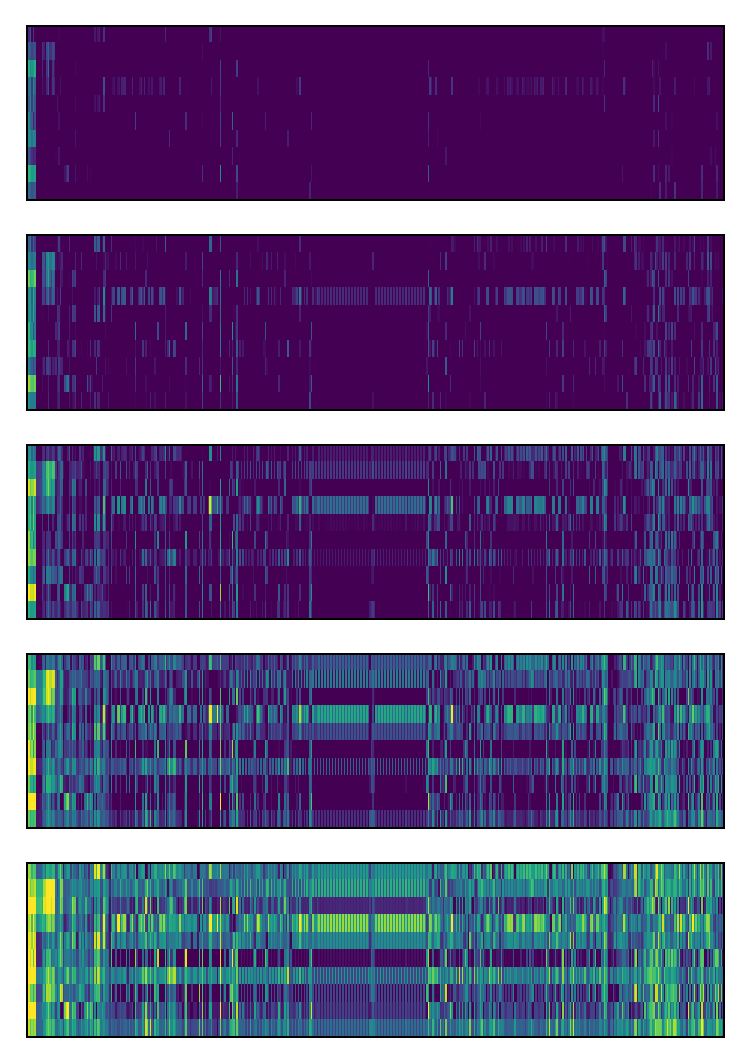

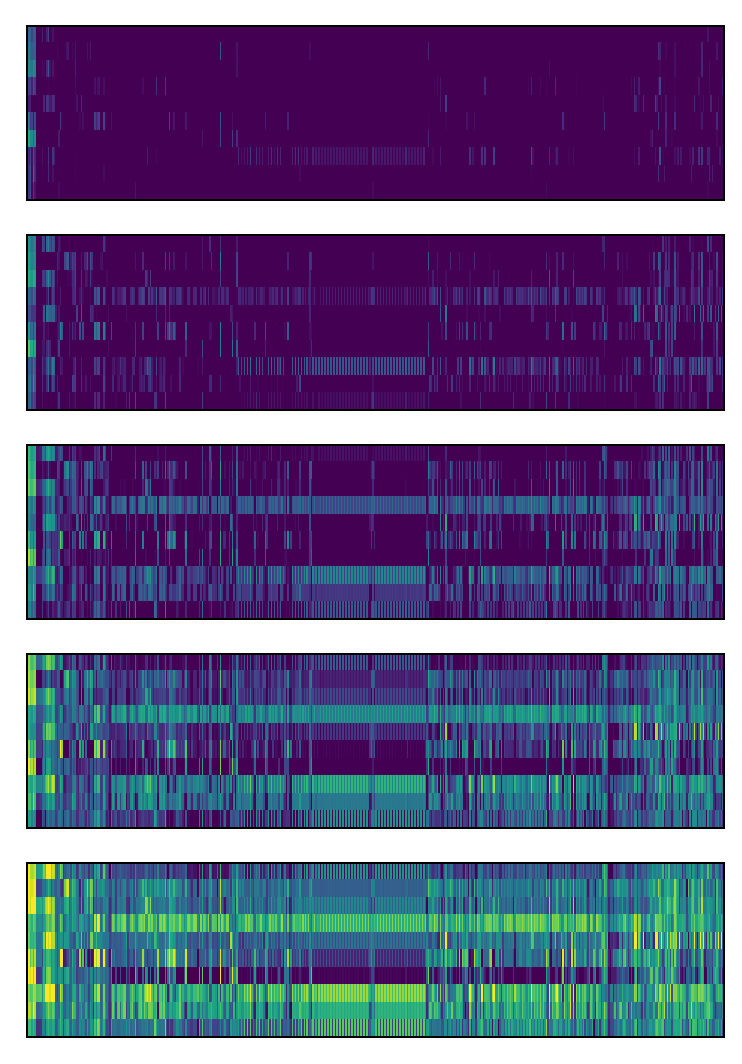

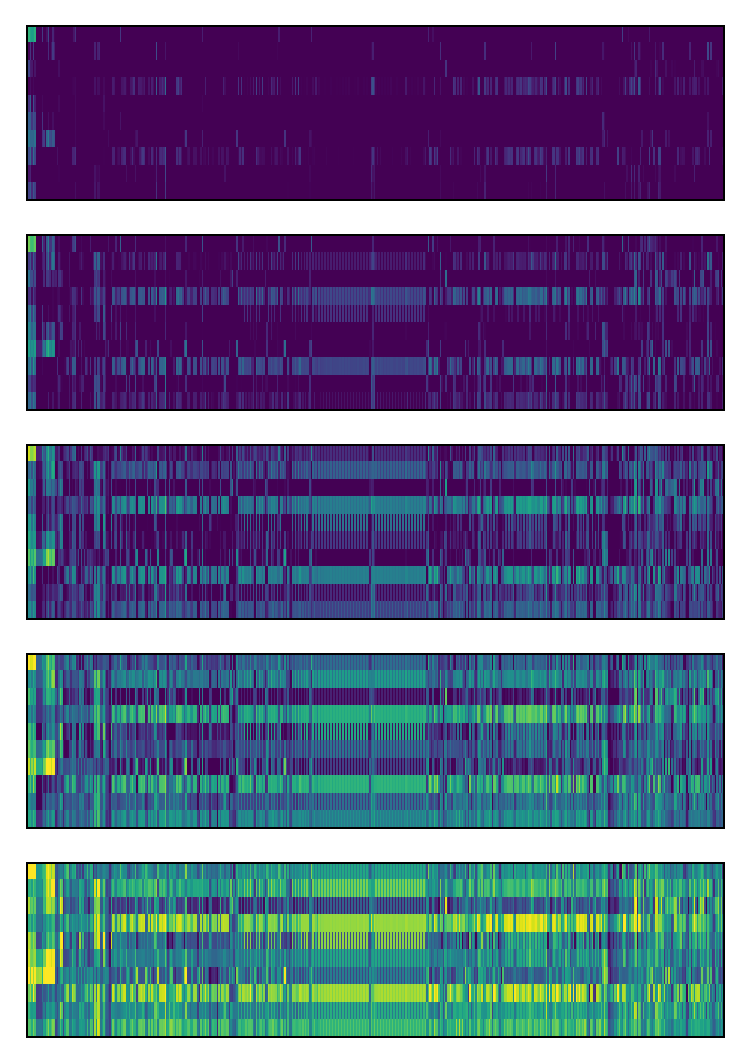

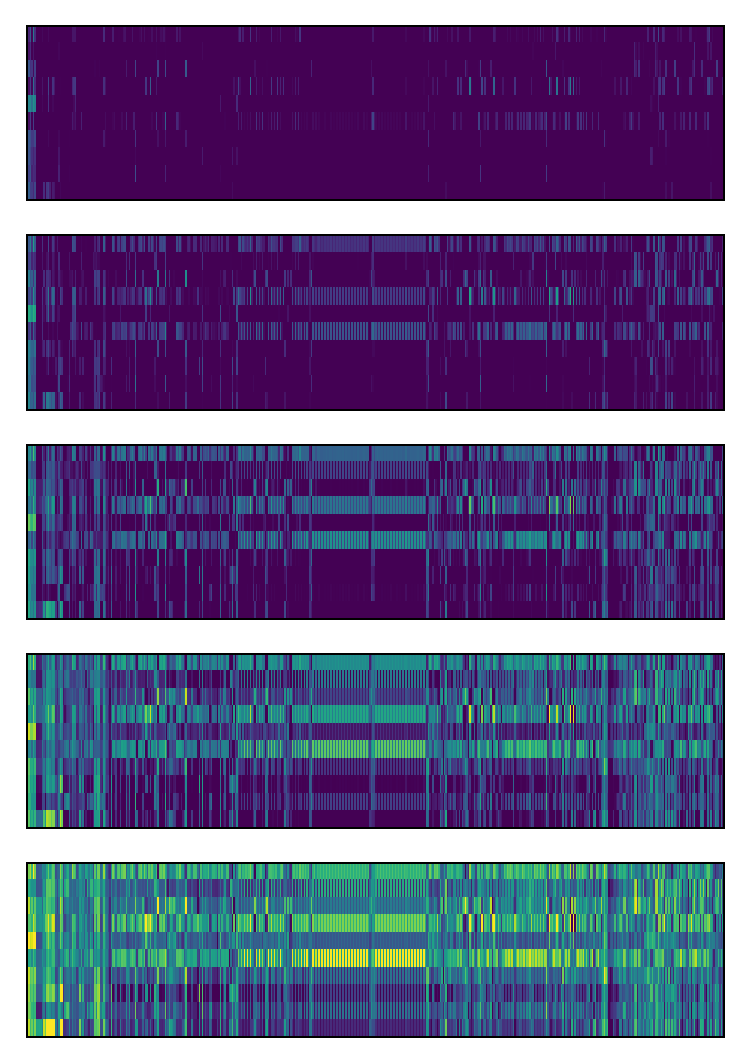

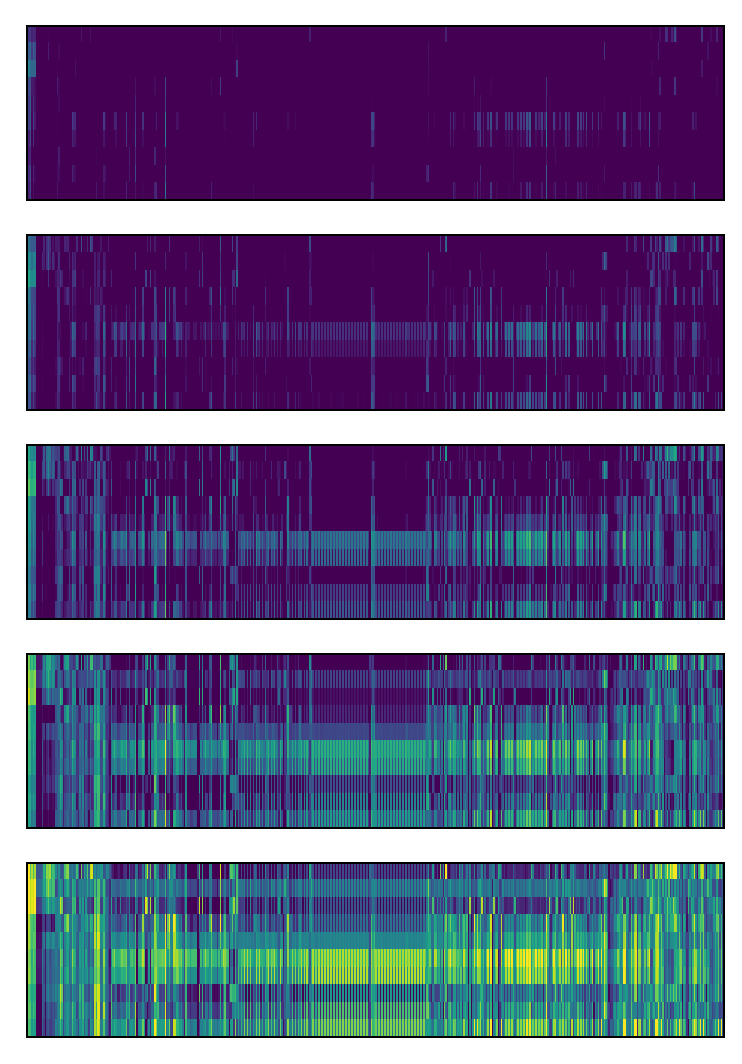

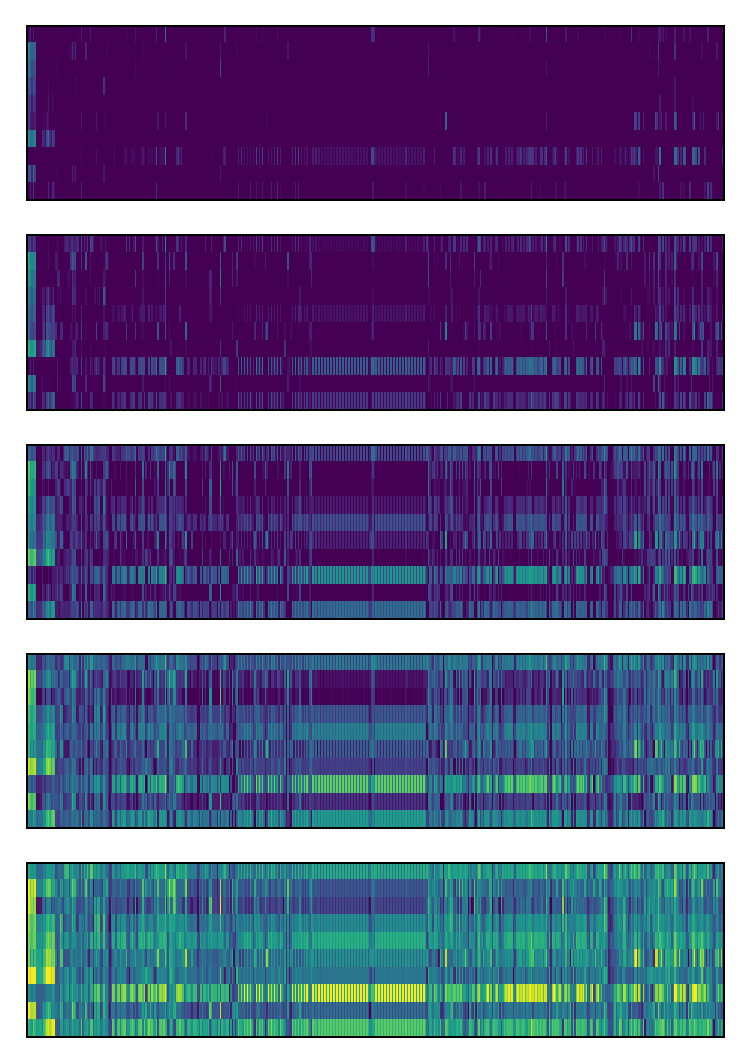

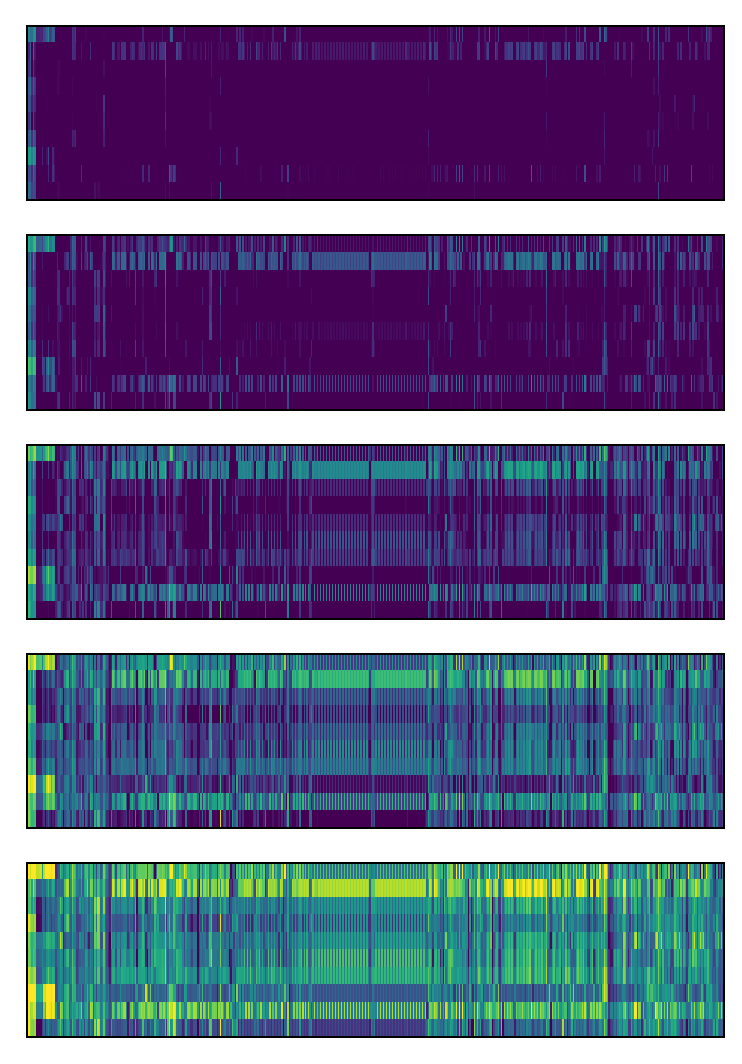

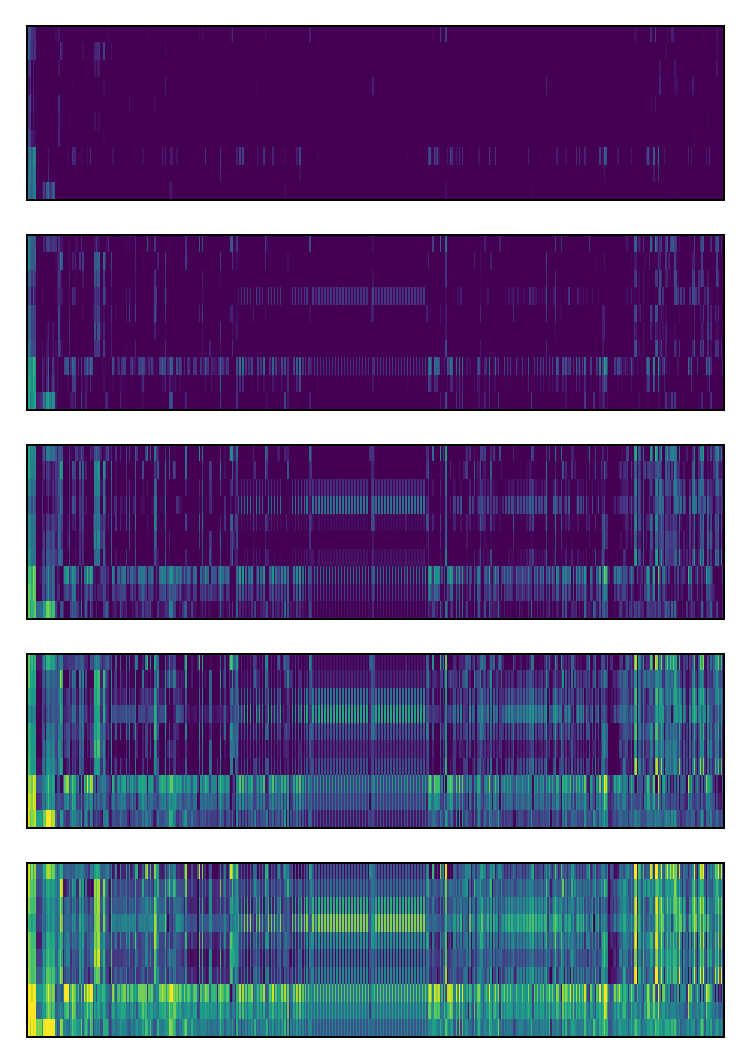

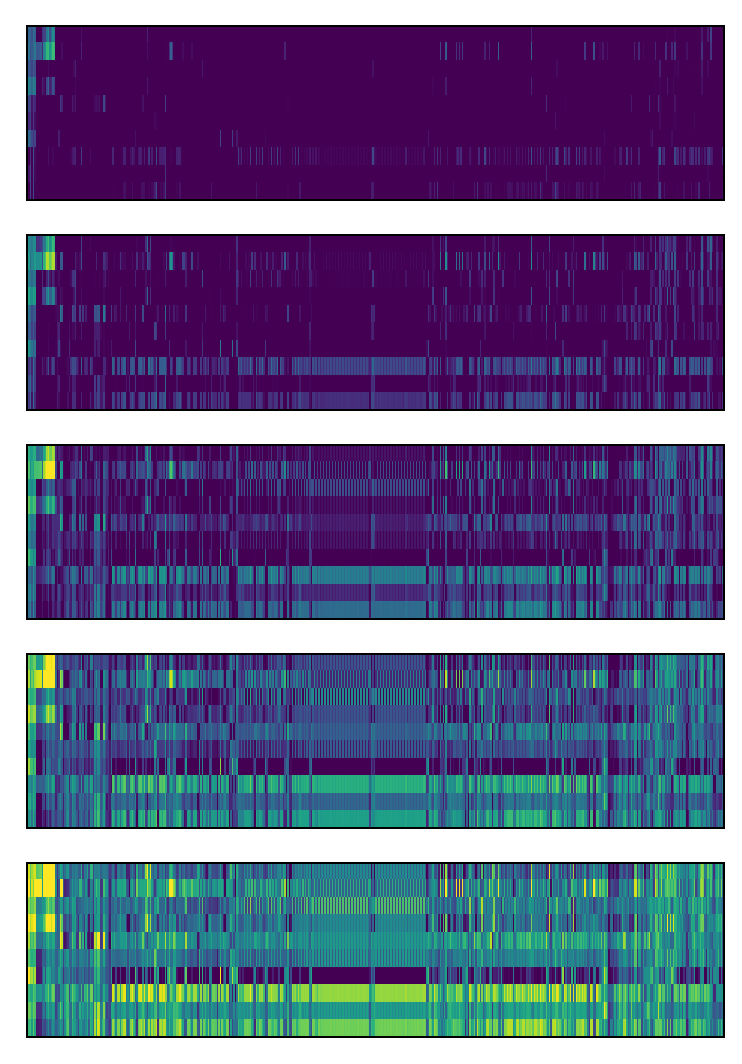

In [106]:
err_steps = list(range(-2, 3))

for k in most_reliable_voxel_means:
    vmax = np.quantile(most_reliable_voxel_means[k] + 2 * most_reliable_voxel_std_err[k], 0.99)
    fig, axes = make_figure(
        [SubplotArtist(width=5, height=0.125 * len(most_reliable_voxel_means[k])) for err_step in err_steps], dpi=180, 
        num_columns=1)
    for err_step, ax in zip(err_steps, axes):
        matshow(ax, np.maximum(most_reliable_voxel_means[k] + err_step * most_reliable_voxel_std_err[k], 0), vmin=0, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.show()


In [108]:
volume_dict = OrderedDict()
for k in most_reliable_voxel_indices:
    indicator_reliable = np.full(bootstrap_indicator_fmri_stat_sig[k].shape, 0)
    indicator_reliable[most_reliable_voxel_indices[k]] = 1
    volume_dict[k[-1]] = make_volume(indicator_reliable, k[-1], cmap='Blues', vmin=0, vmax=1)
                
cortex.webshow(volume_dict, open_browser=False)

Started server on port 56456


<WebApp(Thread-10, started 140470956971776)>

In [50]:
# indicator_good_feature = np.logical_not(indicator_bad_feature)
assert(np.sum(indicator_good_feature) == combined_mean.shape[1])

bootstrap_result_dict = dict()
bootstrap_result_dict['feature_names_non_fmri'] = list(n for n in ordered_names if not n.startswith('hp_fmri_'))
bootstrap_result_dict['indicator_stat_sig_non_fmri'] = indicator_good_feature
bootstrap_result_dict['mean_similarities'] = combined_mean
bootstrap_result_dict['std_similarities'] = combined_std
for k_labels, k in zip(labels, bootstrap_indicator_fmri_stat_sig):
    assert(np.sum(bootstrap_indicator_fmri_stat_sig[k]) == len(k_labels))
    bootstrap_result_dict['labels_{}'.format(k)] = k_labels
    bootstrap_result_dict['stat_sig_{}'.format(k)] = bootstrap_indicator_fmri_stat_sig[k]

np.savez('bootstrap_similarities_kmeans_3.npz', **bootstrap_result_dict)

In [2]:
# bootstrap_result_dict = np.load('bootstrap_similarities_kmeans_3.npz')
# non_fmri_names = bootstrap_result_dict['feature_names_non_fmri']
# indicator_good_feature = bootstrap_result_dict['indicator_stat_sig_non_fmri']
# combined_mean = bootstrap_result_dict['mean_similarities']
# combined_std = bootstrap_result_dict['std_similarities']

['fmri_0', 'fmri_1', 'fmri_2']


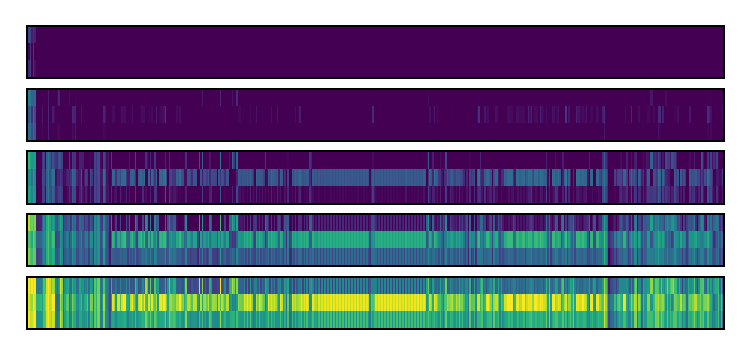

['elan', 'lan', 'n400', 'epnp', 'p600', 'pnp']


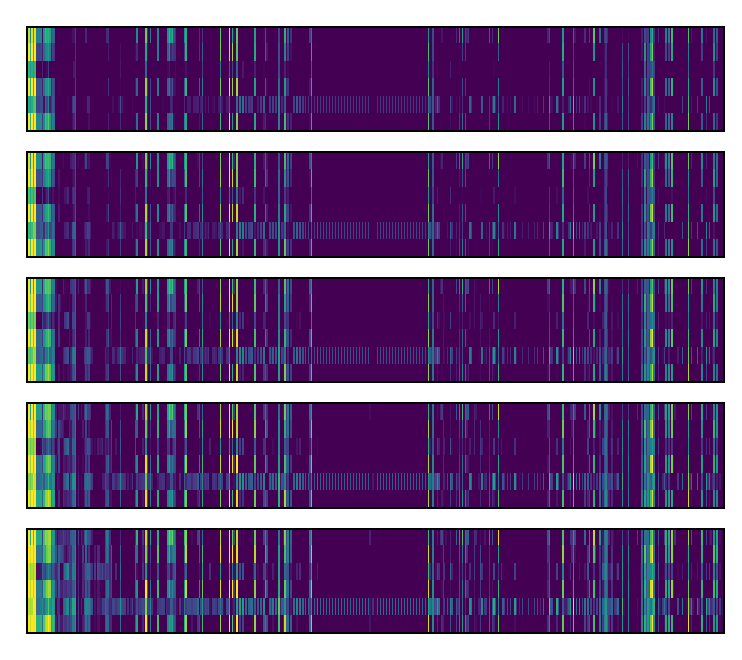

['first_fixation', 'first_pass', 'right_bounded', 'go_past', 'word_first_fixation_duration', 'word_fixation_count', 'word_gaze_duration', 'word_go_past_time', 'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd']


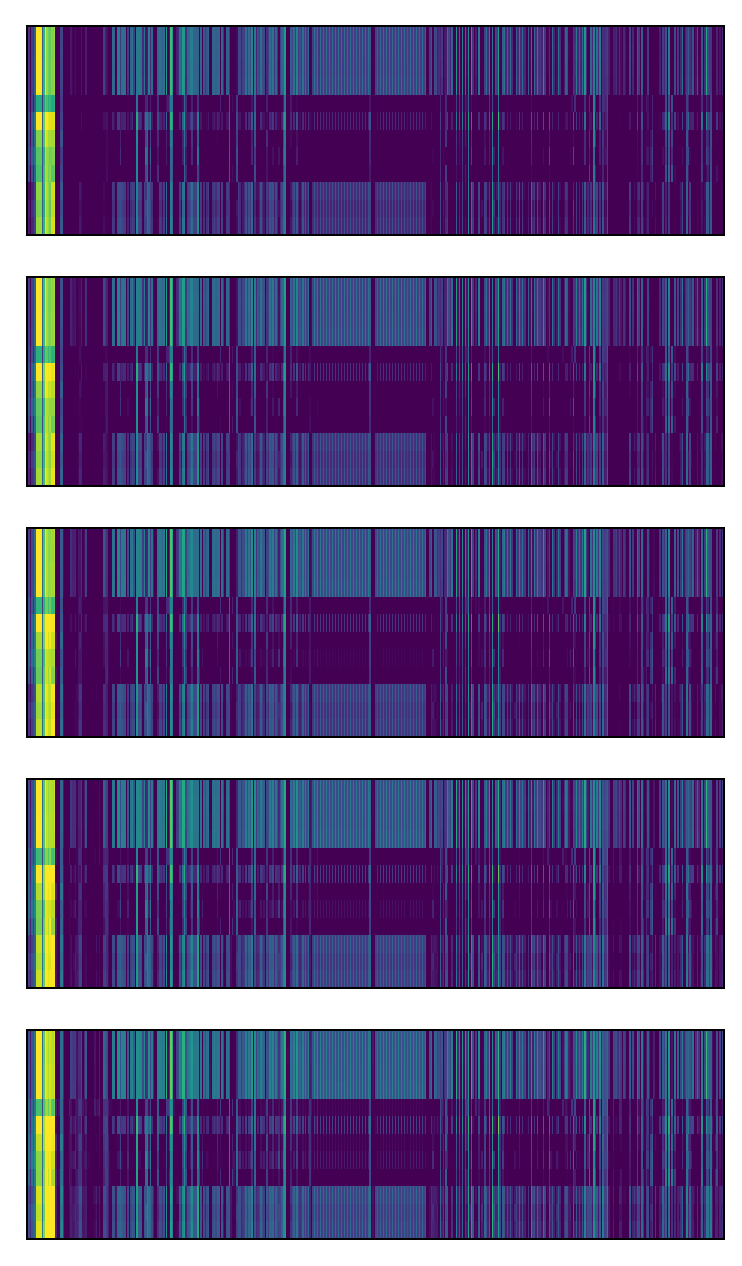

['reading_time']


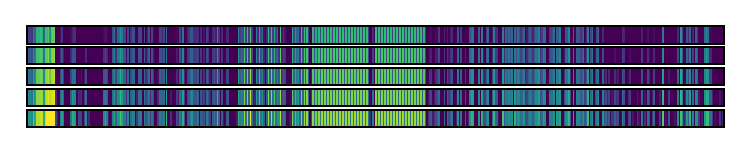

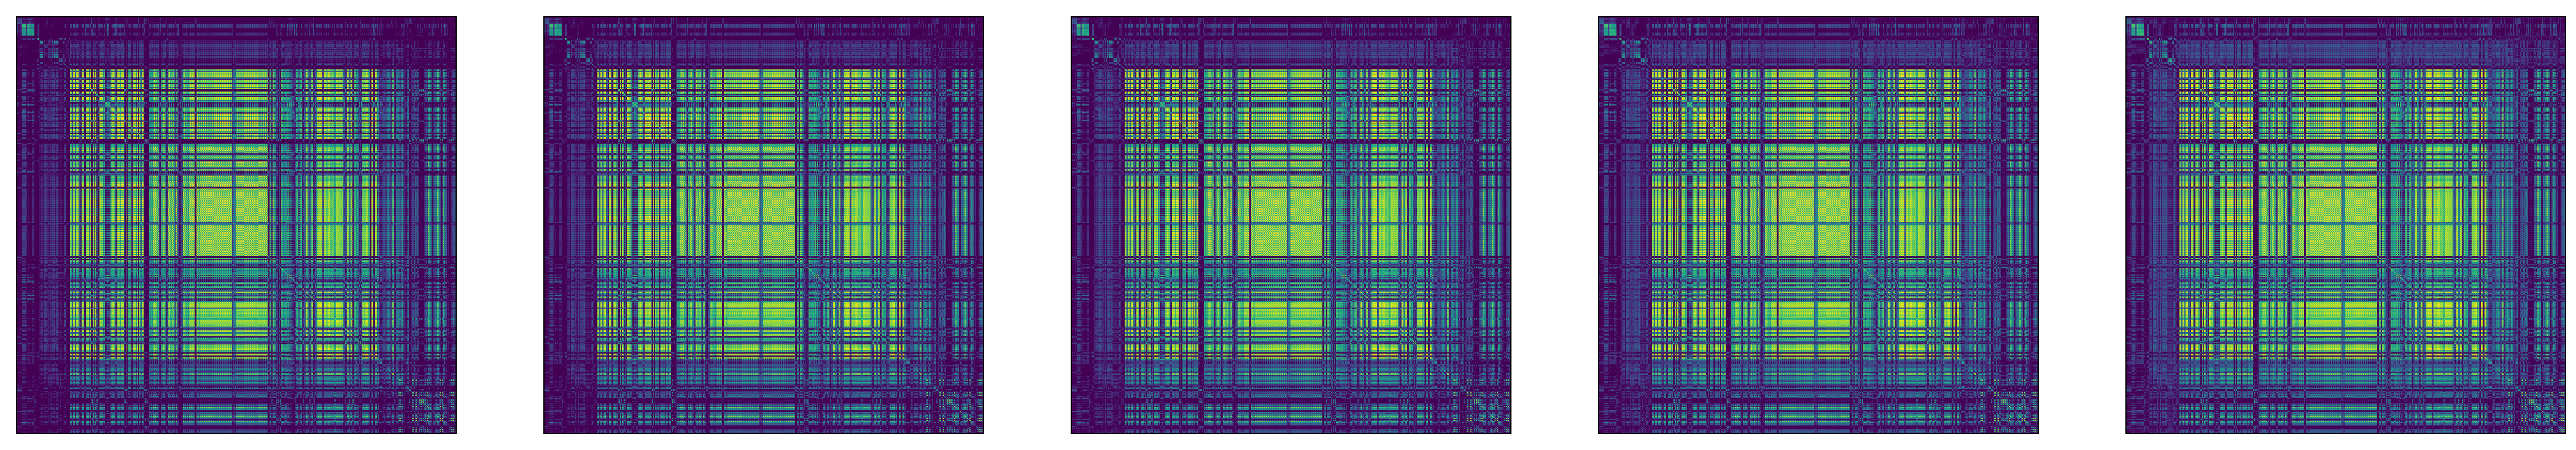

In [4]:
combined_mean_good = combined_mean[np.concatenate([np.array([True, True, True]), indicator_good_feature])]
combined_std_good = combined_std[np.concatenate([np.array([True, True, True]), indicator_good_feature])]

# non_fmri_names = list(n for n in ordered_names if not n.startswith('hp_fmri_'))
good_names = list(n for n, is_good in zip(non_fmri_names, indicator_good_feature) if is_good)

err_steps = list(range(-2, 3))

erp_set = {'n400', 'p600', 'pnp', 'epnp', 'elan', 'lan'}
eye_tracking_set = {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}
reading_time_set = {'reading_time'}

for set_names in [None, erp_set, eye_tracking_set, reading_time_set]:
    if set_names is None:  # fmri
        indices = np.array([0, 1, 2])
        names = list('fmri_{}'.format(idx) for idx in indices)
    else:
        indices = np.array(list(i + 3 for i, n in enumerate(good_names) if n in set_names))
        names = list(good_names[i - 3] for i in indices)
    print(names)
    vmax = np.quantile(combined_mean_good[indices] + 2 * combined_std_good[indices], 0.99)
    fig, axes = make_figure(
        [SubplotArtist(width=5, height=0.125 * len(indices)) for err_step in err_steps], dpi=180, 
        num_columns=1)
    for err_step, ax in zip(err_steps, axes):
        matshow(ax, np.maximum(combined_mean_good[indices] + err_step * combined_std_good[indices], 0), vmin=0, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.show()

vmax = np.quantile(combined_mean_good + 2 * combined_std_good, 0.99)

fig, axes = make_figure([SubplotArtist(width=5, height=5) for err_step in err_steps], dpi=180)
for err_step, ax in zip(err_steps, axes):
    matshow(ax, np.maximum(combined_mean_good + err_step * combined_std_good, 0), vmin=0, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
fig.show()


In [ ]:
num_neighbors = 20
indices_sort = np.argsort(-combined_mean_good, axis=1)
indices_sort = indices_sort[:, :(num_neighbors + 1)]
assert(len(good_names) == combined_mean_good.shape[1])

class LatexNearestTable:
    
    def __init__(self, num_neighbors):
        self.vmax = None
        self.neighbors = list()
        self.neighbor_values = list()
        self.names = list()
        self.num_neighbors = num_neighbors
        
    def clean(self, s):
        if s.startswith('hp_fmri_'):
            s = s[len('hp_fmri_'):]
        if s.startswith('top_const'):
            idx_top_const = 0
            for n in good_names:
                if n == s:
                    break
                elif n.startswith('top_const'):
                    idx_top_const += 1
            return 'tc.{}'.format(idx_top_const) 
        if s.startswith('ner_conll'):
            s = 'ne' + s[len('ner_conll'):]
        if s.startswith('srl_conll'):
            idx_srl = 0
            for n in good_names:
                if n == s:
                    break
                elif n.startswith('srl_conll'):
                    idx_srl += 1
            s = s.split('.')
            s = 'sr.{}.'.format(idx_srl) + s[-1]
        if s.startswith('sem_eval'):
            s = 'se' + s[len('sem_eval'):]
        if s.startswith('pos_conll.'):
            s = s[len('pos_conll.'):]
        if s.startswith('const_conll'):
            s = 'c' + s[len('const_conll'):]
        if s.startswith('coref_conll'):
            s = 'coref' + s[len('coref_conll'):]
        if s.startswith('dep_ewt'):
            idx_dep = 0
            for n in good_names:
                if n == s:
                    break
                elif n.startswith('dep_ewt'):
                    idx_dep += 1
            s = s.split('.')
            s = 'dp.{}.'.format(idx_dep) + s[-1]
        if s.startswith('spr1_'):
            s = 'pr1.' + s[len('spr1_'):]
        if s.startswith('spr2_'):
            s = 'pr2.' + s[len('spr2_'):]
        if s == 'word_go_past_time':
            return 'g.go'
        if s == 'word_gaze_duration':
            return 'g.fp'
        if s == 'word_first_fixation_duration':
            return 'g.fst'
        if s == 'word_total_reading_time':
            return 'g.trt'
        if s == 'word_fixation_count':
            return 'g.cnt'
        if s == 'go_past':
            return 'u.go'
        if s == 'first_pass':
            return 'u.fp'
        if s == 'first_fixation':
            return 'u.fst'
        if s == 'right_bounded':
            return 'u.rt'
        if s == 'reading_time':
            return 'u.spr'
        if s == 'dun_fst_pst':
            return 'd.fp'
        if s == 'dun_go_pst':
            return 'd.go'
        if s == 'dun_rt_bnd':
            return 'd.rt'
        if s.endswith('span0'):
            s = s[:-len('span0')] + '0'
        if s.endswith('span1'):
            s = s[:-len('span1')] + '1'
        s = s.replace('Cause-Effect(e1,e2)', 'c-e')
        s = s.replace('Cause-Effect(e2,e1)', 'e-c')
        s = s.replace('Entity-Destination(e1,e2)', 'e-d')
        s = s.replace('Entity-Destination(e2,e1)', 'd-e')
        s = s.replace('Content-Container(e1,e2)', 'c-in')
        s = s.replace('Content-Container(e2,e1)', 'in-c')
        s = s.replace('Member-Collection(e1,e2)', 'm-cl')
        s = s.replace('Member-Collection(e2,e1)', 'cl-m')
        s = s.replace('Instrument-Agency(e1,e2)', 'i-a')
        s = s.replace('Instrument-Agency(e2,e1)', 'a-i')
        s = s.replace('Product-Producer(e1,e2)', 'p-b')
        s = s.replace('Product-Producer(e2,e1)', 'b-p')
        s = s.replace('exists_as_physical', 'epys')
        s = s.replace('location_of_event', 'loc')
        s = s.replace('Component-Whole(e1,e2)', 'c-w')
        s = s.replace('Component-Whole(e2,e1)', 'w-c')
        s = s.replace('Message-Topic(e1,e2)', 'm-t')
        s = s.replace('Message-Topic(e2,e1)', 't-m')
        s = s.replace('Entity-Origin(e2,e1)', 'o-e')
        s = s.replace('Entity-Origin(e1,e2)', 'e-o')
        s = s.replace('change_of_state_continuous', 'stc')
        s = s.replace('predicate_changed_argument', 'pma')
        s = s.replace('makes_physical_contact', 'pysc')
        s = s.replace('manipulated_by', 'man')
        s = s.replace('change_of_possession', 'poss')
        s = s.replace('was_for_benefit', 'ben')
        s = s.replace('change_of_state', 'st')
        s = s.replace('existed_before', 'exb')
        s = s.replace('existed_during', 'exd')
        s = s.replace('existed_after', 'exa')
        s = s.replace('man_another', 'ma')  # what is man_another?
        s = s.replace('instigation', 'igt')
        s = s.replace('awareness', 'awr')
        s = s.replace('sentient', 'sn')
        s = s.replace('volition', 'v')
        s = s.replace('stationary', 'nmv')
        s = s.replace('WORK_OF_ART', 'art')
        s = s.replace('QUANTITY', 'qnt')
        s = s.replace('LANGUAGE', 'lng')
        s = s.replace('CARDINAL', 'crd')
        s = s.replace('ORDINAL', 'ord')
        s = s.replace('Other', 'oth')
        s = s.replace('PRODUCT', 'pdt')
        s = s.replace('PERSON', 'psn')
        s = s.replace('PERCENT', '%')
        s = s.replace('tree_depth', 'dpth')
        s = s.replace('sent_len', 'len')
        return s.replace('_', '\\_')
        
    def add(self, name, nearest, values):
        self.names.append(self.clean(name))
        self.neighbors.append([self.clean(n) for n in nearest])
        self.neighbor_values.append(values)
        if self.vmax is None:
            self.vmax = np.max(values)
        else:
            self.vmax = max(self.vmax, np.max(values))
            
    def longest(self):
        all_names = set()
        for row in self.neighbors:
            for n in row:
                all_names.add(n)
        for s in sorted(all_names, key=lambda x: -len(x)):
            print(s)
            
    def write(self, output_file):
        output_file.write(r'\begin{tabular}{' + 'c' * (self.num_neighbors + 1) + '}')
        output_file.write('\n')
        output_file.write(r'  \toprule')
        output_file.write('\n')
        output_file.write(r'  Name  & \multicolumn{' + '{}'.format(self.num_neighbors) + r'}{c}{Nearest Neighbors} \\')
        output_file.write('\n')
        output_file.write(r'  \midrule')
        output_file.write('\n')

        for name, nearest_names, values in zip(self.names, self.neighbors, self.neighbor_values):
            line = '  {}'.format(name)
            for value, nearest in zip(values, nearest_names):
                line += r' & \cellcolor{gray!' + '{}'.format(int(100 * value // vmax)) + '} ' + nearest
            for _ in range(len(nearest_names), num_neighbors):
                line += ' & '
            line += r' \\'
            output_file.write(line)
            output_file.write('\n')
        
        output_file.write(r'  \bottomrule')
        output_file.write('\n')
        output_file.write(r'\end{tabular}')
        output_file.write('\n')
    
table = LatexNearestTable(num_neighbors)
    
# for k in most_reliable_voxel_means:
#     indices_sort_most_reliable = np.argsort(-most_reliable_voxel_means[k], axis=1)
#     indices_sort_most_reliable = indices_sort_most_reliable[:, :(num_neighbors + 1)]
#     for i, nearest in enumerate(indices_sort_most_reliable):
#         nearest = nearest[most_reliable_voxel_means[k][i, nearest] - 2 * most_reliable_voxel_std_err[k][i, nearest] > 0]
#         nearest = nearest[:num_neighbors]
#         name = '{}_{}'.format(k, i)
#         nearest_names = list(good_names[n] for n in nearest)
#         table.add(name, nearest_names, most_reliable_voxel_means[k][i, nearest])
#         fig, ax = make_figure(SubplotArtist(width=5, height=1), dpi=180)
#         bar(ax, 
#             most_reliable_voxel_means[k][i, nearest], 
#             most_reliable_voxel_std_err[k][i, nearest], 
#             name, 
#             nearest_names)
#         fig.show()

for i, nearest in enumerate(indices_sort):
    if i < 3:
        # looser for fMRI
        nearest = nearest[combined_mean_good[i, nearest] - combined_std_good[i, nearest] > 0][:num_neighbors]
        name = 'fmri_{}'.format(i)
    else:
        nearest = nearest[combined_mean_good[i, nearest] - 2 * combined_std_good[i, nearest] > 0]
        nearest = nearest[nearest != i - 3][:num_neighbors]
        name = good_names[i - 3]
    nearest_names = list(good_names[n] for n in nearest)
    table.add(name, nearest_names, combined_mean_good[i, nearest])
#     fig, ax = make_figure(SubplotArtist(width=5, height=1), dpi=180)
#     bar(ax,
#         combined_mean_good[i, nearest], 
#         combined_std_good[i, nearest],
#         name,
#         nearest_names)
#     fig.show()

# table.longest()

with open('latex_nearest.txt', 'wt') as latex_file:
    table.write(latex_file)


In [43]:
from subplot_artist import SubplotArtistGrid
import matplotlib
num_neighbors = 20
indices_sort = np.argsort(-combined_mean_good, axis=1)
indices_sort = indices_sort[:, :(num_neighbors + 1)]
assert(len(good_names) == combined_mean_good.shape[1])
    
# for k in most_reliable_voxel_means:
#     indices_sort_most_reliable = np.argsort(-most_reliable_voxel_means[k], axis=1)
#     indices_sort_most_reliable = indices_sort_most_reliable[:, :(num_neighbors + 1)]
#     for i, nearest in enumerate(indices_sort_most_reliable):
#         nearest = nearest[most_reliable_voxel_means[k][i, nearest] - 2 * most_reliable_voxel_std_err[k][i, nearest] > 0]
#         nearest = nearest[:num_neighbors]
#         name = '{}_{}'.format(k, i)
#         nearest_names = list(good_names[n] for n in nearest)
#         table.add(name, nearest_names, most_reliable_voxel_means[k][i, nearest])
#         fig, ax = make_figure(SubplotArtist(width=5, height=1), dpi=180)
#         bar(ax, 
#             most_reliable_voxel_means[k][i, nearest], 
#             most_reliable_voxel_std_err[k][i, nearest], 
#             name, 
#             nearest_names)
#         fig.show()

erp_set = {'n400', 'p600', 'pnp', 'epnp', 'elan', 'lan'}
eye_tracking_set = {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}
reading_time_set = {'reading_time'}

groups = OrderedDict()

for i, nearest in enumerate(indices_sort):
    if i < 3:
        # looser for fMRI
        nearest = nearest[combined_mean_good[i, nearest] - combined_std_good[i, nearest] > 0][:num_neighbors]
        name = 'fmri_{}'.format(i)
    else:
        nearest = nearest[combined_mean_good[i, nearest] - 2 * combined_std_good[i, nearest] > 0]
        nearest = nearest[nearest != i - 3][:num_neighbors]
        name = good_names[i - 3]
    nearest_names = list(good_names[n] for n in nearest)
    if name.startswith('fmri_'):
        group = 'fmri'
    elif name in erp_set:
        group = 'erp'
    elif name in eye_tracking_set:
        group = 'eye'
    elif name in reading_time_set:
        group = 'read'
    else:
        group = 'other'
    if group not in groups:
        groups[group] = list()
    groups[group].append((i, name, nearest_names, nearest))


# combine eye and read into a single group
groups['eye'].extend(groups['read'])
del groups['read']


def get_colors(map_name='tab10'):
    colormap_counts = {
        'Pastel1': 9,
        'Pastel2': 8,
        'Paired': 12,
        'Accent': 8,
        'Dark': 8,
        'Set1': 9,
        'Set2': 8,
        'Set3': 12,
        'tab10': 10,
        'tab20': 20,
        'tab20b': 20,
        'tab20c': 20
    }
    
    if map_name == 'tab20_light':
        return [c for i, c in enumerate(get_colors('tab20')) if i % 2 == 1]
            
    cmap = matplotlib.cm.get_cmap(map_name)
    return list(cmap(i / colormap_counts[map_name]) for i in range(colormap_counts[map_name]))
        
colors = get_colors('tab20_light')
patterns = (None, '//', '\\', '-', '+', 'x', '*', 'o', 'O', '.')

def fix_name(s):
    if s.startswith('spr1_'):
        s = 'pr1.' + s[len('spr1_'):]
    if s.startswith('spr2_'):
        s = 'pr2.' + s[len('spr2_'):]
    if s.startswith('sem_eval.'):
        return 'se.' + s[len('sem_eval.'):]
    if s == 'word_go_past_time':
        return 'g.go'
    if s == 'word_gaze_duration':
        return 'g.fp'
    if s == 'word_first_fixation_duration':
        return 'g.fst'
    if s == 'word_total_reading_time':
        return 'g.trt'
    if s == 'word_fixation_count':
        return 'g.cnt'
    if s == 'go_past':
        return 'u.go'
    if s == 'first_pass':
        return 'u.fp'
    if s == 'first_fixation':
        return 'u.fst'
    if s == 'right_bounded':
        return 'u.rt'
    if s == 'reading_time':
        return 'u.spr'
    if s == 'dun_fst_pst':
        return 'd.fp'
    if s == 'dun_go_pst':
        return 'd.go'
    if s == 'dun_rt_bnd':
        return 'd.rt'
    if s.startswith('dep_ewt.'):
        return 'dp.' + s[len('dep_ewt.'):]
    if s.startswith('const_conll.'):
        return 'c.' + s[len('const_conll.'):]
    if s.startswith('top_const.'):
        return 'tc.' + s[len('top_const.'):]
    if s.startswith('pos_conll.'):
        return s[len('pos_conll.'):]
    if s.startswith('srl_conll.'):
        return 'sr.' + s[len('srl_conll.'):]
    return s.replace('_conll.', '.').replace('manipulated_by_another', 'man')

for group_name in groups:
    
    if group_name != 'erp':
        continue
    
    group = groups[group_name]

    fig, axes = make_figure([SubplotArtist(width=1.8, height=5) for _ in range(len(group) + 1)], num_columns=4, dpi=180)
    for ax, (i, name, nearest_names, nearest) in zip(axes[:-1], group):
        bars = ax.barh(
            len(nearest) - 1 - np.arange(len(nearest)), 
            combined_mean_good[i, nearest])
        ax.errorbar(
            y=len(nearest) - 0.7 - np.arange(len(nearest)), 
            x=combined_mean_good[i, nearest], 
            xerr=combined_std_good[i, nearest],
            fmt='none',
            ecolor='black',
            elinewidth=1)
        for bar, k in zip(bars, nearest_names):
            if k in erp_set:
                color = colors[0]
            elif k in eye_tracking_set:
                color = colors[1]
            elif k.startswith('srl_conll') or k.startswith('spr1_') or k.startswith('spr2_'):
                color = colors[2]
            elif k.startswith('ner_conll'):
                color = colors[3]
            elif k.startswith('sem_eval'):
                color = colors[4]
            elif k.startswith('top_const') \
                    or k.startswith('const_conll') \
                    or k.startswith('pos_conll') \
                    or k == 'obj_num' \
                    or k == 'subj_num' \
                    or k == 'tense':
                color = colors[5]
            elif k.startswith('dep_ewt'):
                color = colors[6]
            elif k.startswith('tree_depth') or k.startswith('sent_len.'):
                color = colors[7]
            else:
                color = colors[8]
            bar.set_color(color)
        name = fix_name(name)
        if name.startswith('se.') or name.startswith('pr1.') or name.startswith('pr2.'):
            ax.set_title(name, fontsize=6)
        else:
            ax.set_title(name)
        ax.set_yticklabels([fix_name(s) for s in reversed(nearest_names)], horizontalalignment='left')
        ax.set_yticks(np.arange(len(nearest_names)))
        ax.tick_params(axis='y', direction='in', length=0, pad=-5, labelsize=6)
    ax = axes[-1]
    legend = [
        'ERP', 
        'Eye-tracking', 
        'Semantic role', 
        'Named entity', 
        'SemEval', 
        'PoS/Constit.', 
        'Dependency role',
        'Tree-depth/Sent. length',
        'Coref']
    # fig, ax = make_figure(SubplotArtist(width=1.8, height=5), dpi=180)
    bars = ax.barh(
        len(legend) - 1 - np.arange(len(legend)),
        [0.4] * len(legend))
    for bar, c in zip(bars, colors):
        bar.set_color(c)
    ax.tick_params(axis='y', direction='in', length=0, pad=-5, labelsize=8)
    ax.set_yticklabels([lbl for lbl in reversed(legend)], horizontalalignment='left')
    ax.set_yticks(np.arange(len(legend)))
    ax.set_xticks([])
    ax.set_title('Legend')
    fig.show('erp_similarities.pdf'.format(idx_part), is_tight_layout=True)


In [27]:
volume_dict = OrderedDict()
for key in label_dict:
    volume_dict[key[-1]] = make_volume(label_dict[key], key[-1], cmap='Accent', vmin=0, vmax=9)
    
cortex.webshow(volume_dict, open_browser=False)

Started server on port 33081


<WebApp(Thread-8, started 140470948579072)>

Stopping server
Stopping server


In [ ]:
# print_variation_results(paths, 'fmri_cram_cpg_prop_wide', index_run=0)
print_variation_results(paths, 'fmri_raw_dds_direct')
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(0, num_runs, 4))
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(1, num_runs, 4))
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(2, num_runs, 4))
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(3, num_runs, 4))

/usr0/home/drschwar/src/bert_brain/bert_brain/loss_curves.py:37: RuntimeWarning: Mean of empty slice
  epoch_values.append(np.nanmean(curve.values[curve.epochs == epoch]))


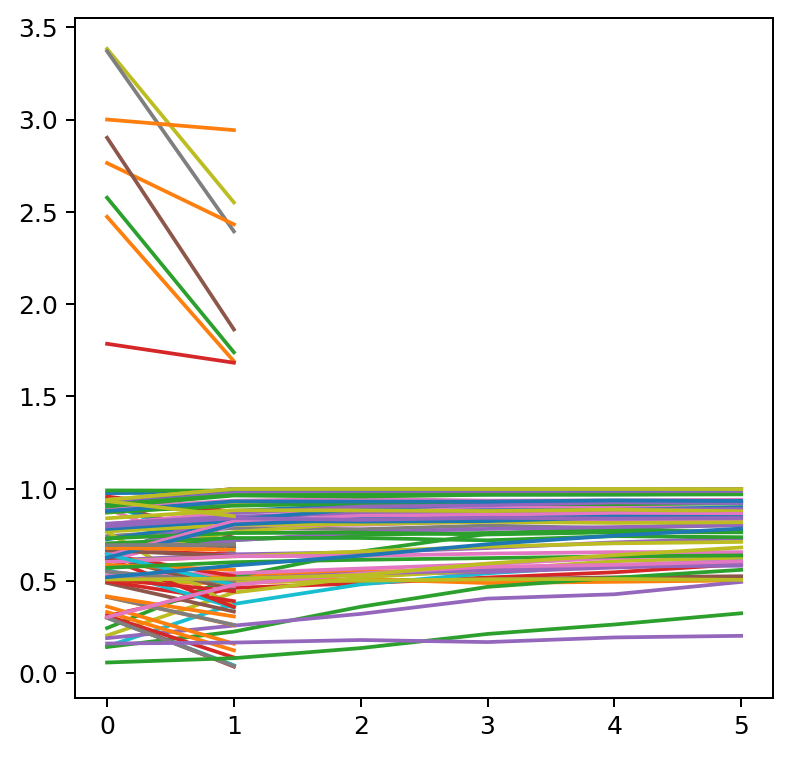

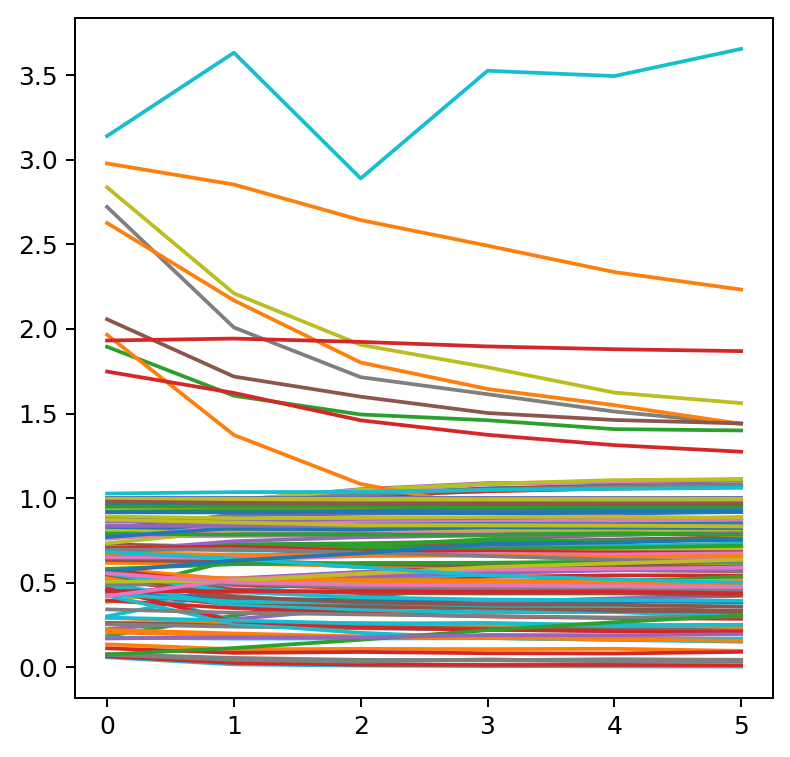

bshift 0 train 0 0.6943666599155403
bshift.acc 1 train 5 0.6087761876588301
const_conll 2 train 1 1.7389791187486625
const_conll.acc 3 train 5 0.5913356826357357
coord_inv 4 train 0 0.69599678995625
coord_inv.acc 5 train 5 0.5260213279170138
coref_conll 6 train 1 0.4734135168962272
coref_conll.acc 7 train 5 0.8032874489597465
dep_ewt 8 train 1 2.5509662058569966
dep_ewt.acc 9 train 5 0.609725897339391
dpr 10 train 0 0.7027402044478843
dpr.acc 11 train 2 0.5105184968180271
dun_fst_pst 12 train 1 0.8557162450926539
dun_go_pst 13 train 1 0.8751660895785686
dun_rt_bnd 14 train 0 0.9422403864045227
elan 15 train 1 0.7348469887478424
epnp 16 train 0 0.9145316316237588
first_fixation 17 train 0 0.7756417332804293
first_pass 18 train 1 0.3598683063552435
go_past 19 train 0 0.792016145080218
hp_fmri_F 20 train 0 0.9762177010279623
hp_fmri_G 21 train 0 0.9726013501577355
hp_fmri_H 22 train 1 0.9896681623514041
hp_fmri_I 23 train 1 0.9812332169852964
hp_fmri_J 24 train 0 0.9831716384058587
hp_fmr

In [2]:
variation = 'fmri_raw_dds_direct'
curves = loss_curves_for_variation(paths, variation)

average_unique_epochs_within_loss_curves(curves)
curves = average_over_runs(curves)    
train_curves = [c for c in curves if c.train_eval_kind == 'train']
validation_curves = [c for c in curves if c.train_eval_kind == 'validation']


def print_min_values(curves):
    for i, curve in enumerate(sorted(curves, key=lambda c: c.key)):
        try:
            if curve.key.endswith('.acc'):
                index_best = np.nanargmax(curve.values)
            else:
                index_best = np.nanargmin(curve.values)
            print(curve.key, i, curve.train_eval_kind, index_best, curve.values[index_best])
        except ValueError:
            pass

        
def render_curves(ax, curves):
    for curve in sorted(curves, key=lambda c: c.key):
        ax.plot(curve.epochs, curve.values, label=curve.key)


fig, ax = make_figure(SubplotArtist(width=5, height=5), dpi=180)
render_curves(ax, train_curves)
fig.show()

fig, ax = make_figure(SubplotArtist(width=5, height=5), dpi=180)
render_curves(ax, validation_curves)
fig.show()

print_min_values(train_curves)
print('')
print_min_values(validation_curves)